# Final Project - DelaySense

## 1. Import Libraries

In [1]:
# !pip install phik

In [2]:
# !pip install feature-engine

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import joblib

from phik import phik_matrix
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,make_scorer


## 2. Load Data

In [ ]:
df = pd.read_csv('FP_DelaySense_dataset_DS.csv')

## 3. Split X and y

In [5]:
# Split X dan y
X = df.drop('reached_on_time', axis=1)
y = df['reached_on_time']

In [6]:
# Split Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (8799, 13)
Test Size  :  (2200, 13)


In [7]:
X_train.head()

,index,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,weight_category
3814,3814,3815,C,Road,3,4,231,2,high,F,6,4452,Intermediate Weight
1845,1845,1846,B,Ship,4,4,201,10,medium,M,17,2059,Medium Weight
10602,10602,10603,D,Ship,5,2,176,4,low,M,1,5810,High Weight
8329,8329,8330,F,Ship,5,1,232,5,low,M,4,1776,Medium Weight
3990,3990,3991,D,Ship,6,3,205,3,low,M,10,4996,High Weight


In [8]:
#Split num and cat
num_cols = ['customer_care_calls','customer_rating' ,'cost_of_the_product','prior_purchases' , 'discount_offered']
cat_cols = ['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender', 'weight_category']

print('Num Columns : ', num_cols)
print('Cat Columns : ', cat_cols)

Num Columns :  ['customer_care_calls', 'customer_rating', 'cost_of_the_product', 'prior_purchases', 'discount_offered']
Cat Columns :  ['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender', 'weight_category']


## 4. Handling Outliers

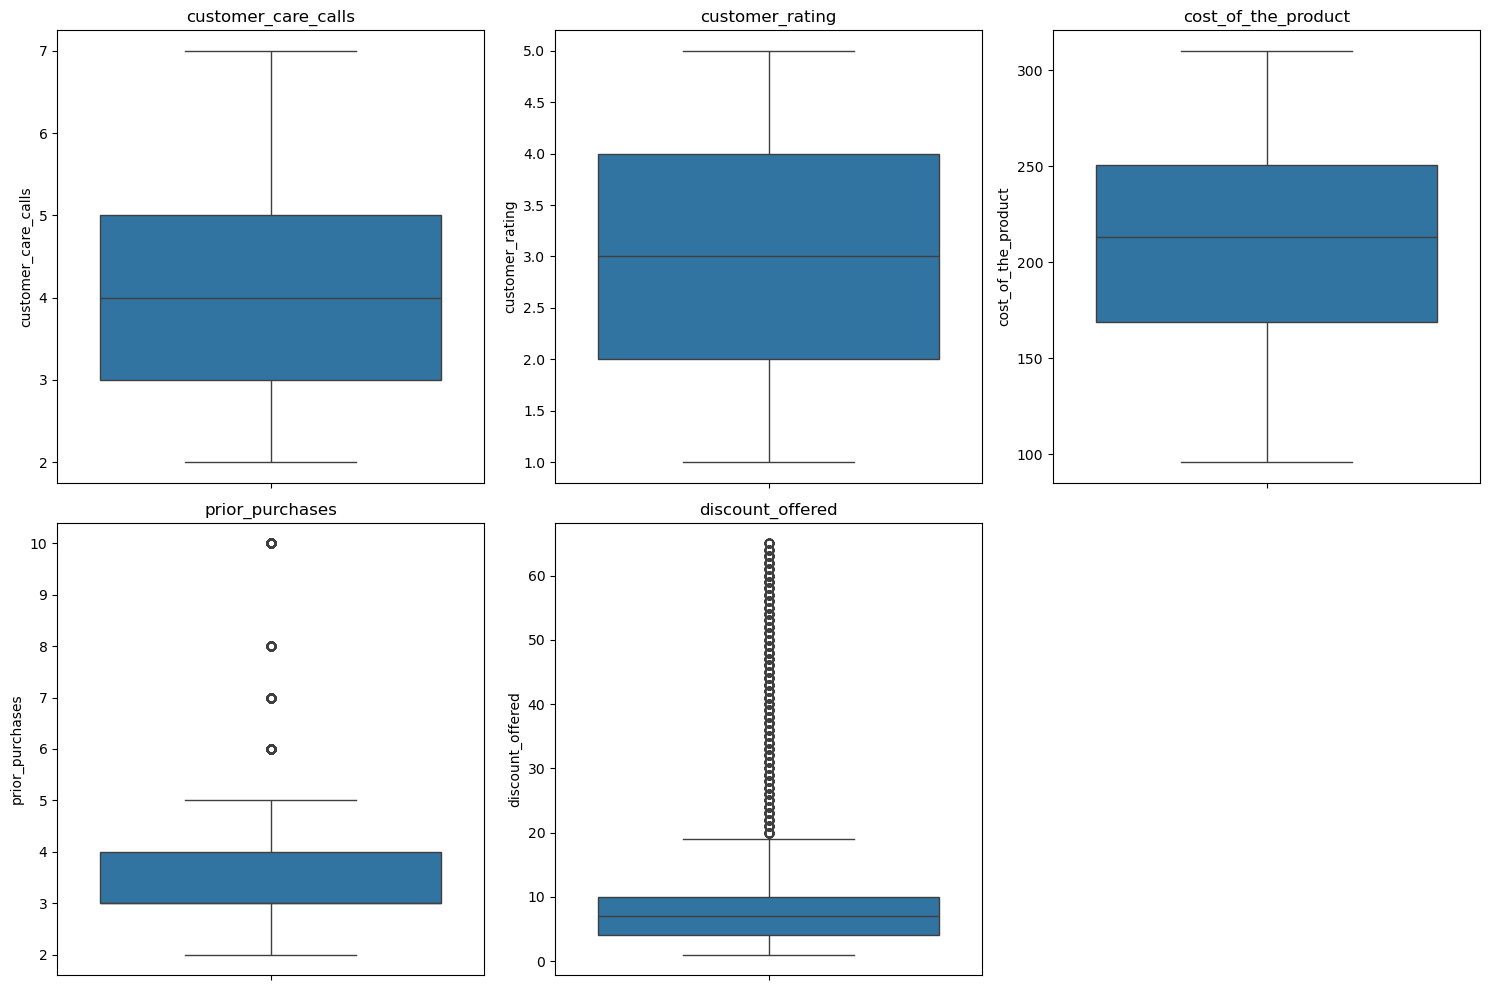

In [9]:
# Gunakan num_cols sebagai list fitur
features = num_cols
num_features = len(features)

# Atur layout subplot
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(15, 5 * rows))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=X_train, y=feature)
    plt.title(feature)

plt.tight_layout()
plt.show()


In [10]:
inc_columns = ['prior_purchases' , 'discount_offered']

# membuat Winsorizer transformer untuk handling outlier dengan nilai maximum dan minimum variabelnya
winsorizer = Winsorizer(capping_method='quantiles', tail='both', fold=0.05, variables=inc_columns)

# fit transformer ke dataset
winsorizer.fit(X_train)

# transform dataset
X_train_winsorized = winsorizer.transform(X_train)

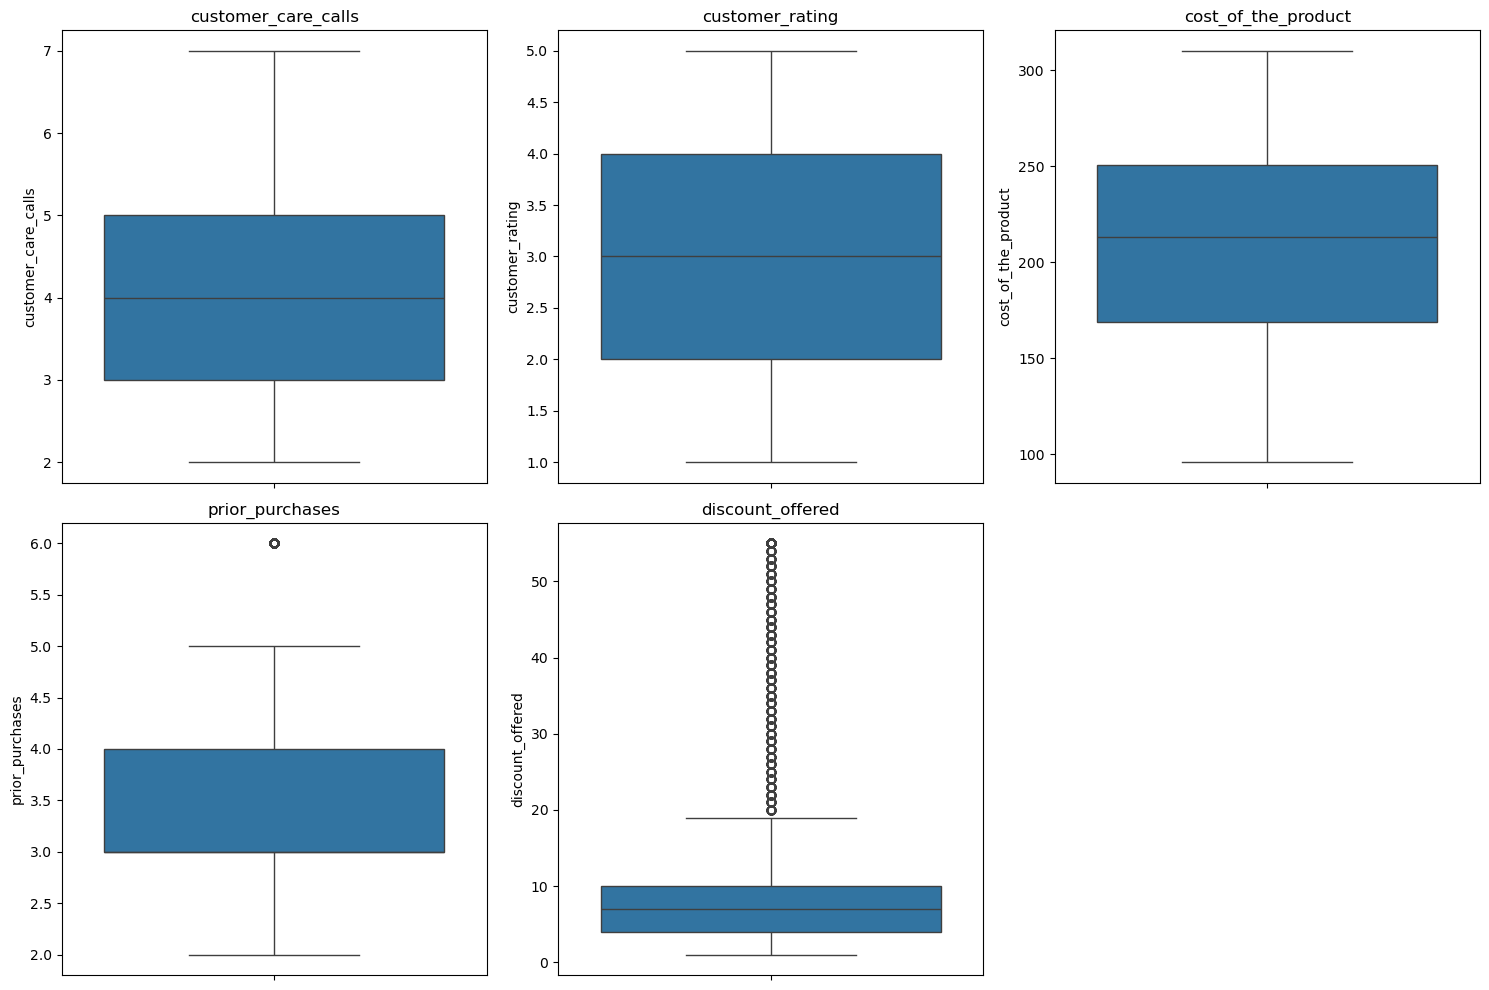

In [11]:
# Gunakan num_cols sebagai list fitur
features = num_cols
num_features = len(features)

# Atur layout subplot
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(15, 5 * rows))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=X_train_winsorized, y=feature)
    plt.title(feature)

plt.tight_layout()
plt.show()

## 5. Feature Selection

interval columns not set, guessing: ['index', 'id', 'customer_care_calls', 'customer_rating', 'cost_of_the_product', 'prior_purchases', 'discount_offered', 'weight_in_gms', 'reached_on_time']


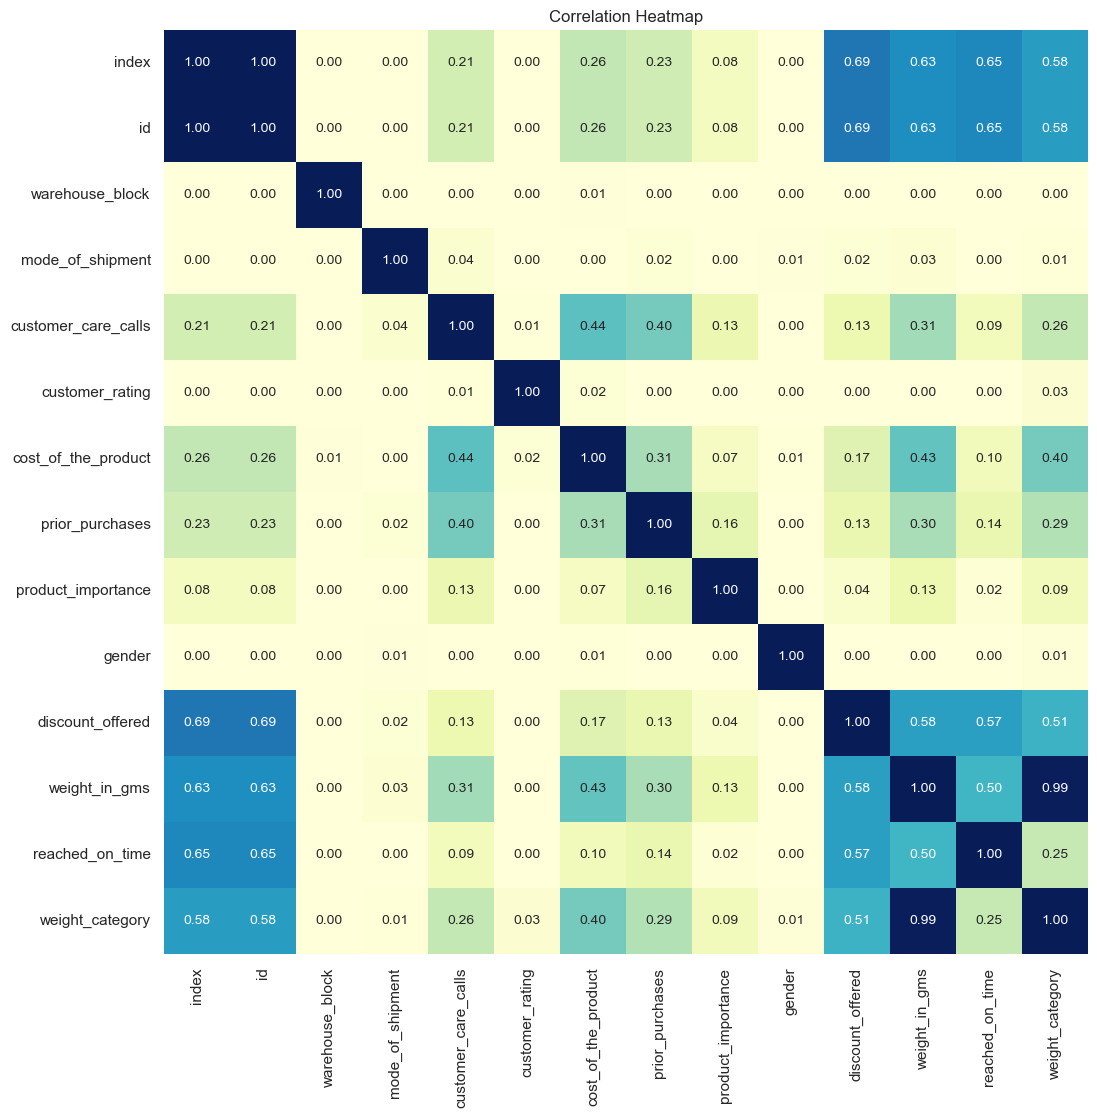

In [12]:
# Check Correlation
corr = df.phik_matrix()

# Membuat heatmap
sns.set(font_scale=1)
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f', annot_kws={'size': 10}, square=True, cbar=False)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
print(corr.loc['reached_on_time'])

index                  0.647577
id                     0.647577
warehouse_block        0.000000
mode_of_shipment       0.000000
customer_care_calls    0.093074
customer_rating        0.000000
cost_of_the_product    0.096365
prior_purchases        0.138591
product_importance     0.018351
gender                 0.000000
discount_offered       0.574382
weight_in_gms          0.500450
reached_on_time        1.000000
weight_category        0.251949
Name: reached_on_time, dtype: float64


## 6. Scaling dan Encoding

In [14]:
num_columns_selected = ['customer_care_calls','customer_rating' ,'cost_of_the_product','prior_purchases' , 'discount_offered']
cat_columns_selected = ['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender', 'weight_category']

# Memilih fitur terseleksi dari DataFrame train_num
X_train_num_selected = X_train_winsorized[num_columns_selected]
X_test_num_selected = X_test[num_columns_selected]

# Memilih fitur terseleksi dari DataFrame train_cat
X_train_cat_selected = X_train[cat_columns_selected]
X_test_cat_selected = X_test[cat_columns_selected]

# Menggabungkan fitur menjadi df_train
X_train_selected = pd.concat([X_train_num_selected, X_train_cat_selected], axis=1)
X_test_selected = pd.concat([X_test_num_selected, X_test_cat_selected], axis=1)

print('Train Size : ', X_train_selected.shape)
print('Test Size  : ', X_test_selected.shape)

Train Size :  (8799, 10)
Test Size  :  (2200, 10)


In [15]:
normal_cols = ['customer_care_calls','customer_rating' ,'cost_of_the_product','prior_purchases']
ot_cols = ['discount_offered']
ohe_cols = ['warehouse_block', 'gender']
ord_cols = ['product_importance', 'weight_category', 'mode_of_shipment']
ordinal_mapping = {
    'product_importance': ['low', 'medium', 'high'],
    'weight_category': ['Low Weight', 'Medium Weight', 'Intermediate Weight', 'High Weight', 'Very High Weight'],
    'mode_of_shipment': ['Flight', 'Ship', 'Road']
}
ordinal_categories = [ordinal_mapping[col] for col in ord_cols]

In [16]:
#Scaling dan encoding menggunakan ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), normal_cols),
        ('robust_scaler', RobustScaler(), ot_cols),
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
        ('cat_ord', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ord_cols)
    ],
    remainder='drop'
)

## 7. Handlng Imbalance

In [17]:
# Cek distribusi kelas di y_train
y_train.value_counts(normalize=True)


reached_on_time
1    0.598136
0    0.401864
Name: proportion, dtype: float64

### Handling Class Imbalance

Variabel target `reached_on_time` menunjukkan sedikit ketidakseimbangan, dengan sekitar **40.2%** pengiriman tiba tepat waktu (kelas `0`) dan **59.8%** mengalami keterlambatan (kelas `1`). Meskipun distribusi ini tidak tergolong sangat timpang, ketidakseimbangan ini tetap dapat menyebabkan bias — terutama pada model seperti **Logistic Regression** atau **SVM** yang sensitif terhadap proporsi kelas.

Karena fokus utama proyek ini adalah **meminimalkan false negative** (yaitu memprediksi bahwa pengiriman akan tiba tepat waktu, padahal sebenarnya terlambat), maka sangat penting agar model mampu belajar secara efektif dari kelas minoritas (`0` = tepat waktu). Bahkan ketidakseimbangan ringan dapat menyebabkan model terlalu condong ke kelas mayoritas (`1` = terlambat), yang pada akhirnya menurunkan **recall** untuk pengiriman tepat waktu — dan ini sangat merugikan.

Untuk meningkatkan kemampuan generalisasi dan menjamin keadilan antar kelas, kami menggunakan **SMOTE (Synthetic Minority Over-sampling Technique)** pada data pelatihan. Teknik ini menyeimbangkan distribusi kelas dengan menghasilkan sampel sintetis untuk kelas minoritas, sehingga model dapat lebih mengenali pola dan meningkatkan **recall** pada kelas yang lebih jarang — yaitu pengiriman tepat waktu.



In [18]:
# fit transform x_train dengan prepocessing
X_train_preprocessed = preprocess.fit_transform(X_train, y_train)

# Gunakan SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_preprocessed, y_train)



In [19]:
# Cek distribusi kelas
pd.Series(y_train_bal).value_counts(normalize=True)

reached_on_time
0    0.5
1    0.5
Name: proportion, dtype: float64

Setelah menerapkan **SMOTE (Synthetic Minority Over-sampling Technique)**, distribusi data berhasil diseimbangkan menjadi **50:50** untuk masing-masing kelas pada variabel target `reached_on_time`.

Langkah selanjutnya adalah melakukan **cross-validation** menggunakan beberapa algoritma machine learning, sepert `Logistic Regression`, `Decision Tree`, `Random Forest`, dan `Support Vector Machine (SVM)`.

Tujuannya adalah untuk menemukan model terbaik dalam mendeteksi keterlambatan pengiriman. Karena fokus utama proyek ini adalah **meminimalkan false negative**, maka metrik evaluasi yang digunakan adalah **recall**, khususnya untuk kelas `0` (pengiriman tepat waktu).


## 8. Cross Validation

In [20]:
# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

# Correct scoring - focus on class 1 (late deliveries)
recall_late = make_scorer(recall_score, pos_label=1)

# Evaluate models using recall for class 1 (late deliveries)
results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring=recall_late)
    mean_score = scores.mean()
    std_score = scores.std()
    results.append((name, mean_score, std_score))

# Print results in a single loop
for name, mean_score, std_score in results:
    print(f"{name} - Recall for Class 1 (Late Deliveries): {mean_score:.4f} ± {std_score:.4f}")


Logistic Regression - Recall for Class 1 (Late Deliveries): 0.5104 ± 0.0130
Decision Tree - Recall for Class 1 (Late Deliveries): 0.6817 ± 0.0138
Random Forest - Recall for Class 1 (Late Deliveries): 0.6172 ± 0.0384
SVM - Recall for Class 1 (Late Deliveries): 0.4440 ± 0.0075


Berdasarkan hasil **cross-validation** yang telah dilakukan pada beberapa algoritma, model **Decision Tree** menunjukkan performa terbaik dengan nilai recall tertinggi sebesar `0.6812` dan nilai standar deviasi terendah yaitu `± 0.0138`. 

Sementara itu, model **Random Forest** juga menunjukkan hasil yang cukup kompetitif dengan nilai recall sebesar `0.6172` dan standar deviasi `± 0.0384`. 

Oleh karena itu, kami akan mencoba kedua model ini terlebih dahulu untuk melihat mana yang menghasilkan output paling baik pada tahap evaluasi lebih lanjut sebelum dilakukan proses **hyperparameter tuning**.




## 9. Model Evaluation

In [21]:
# 1. Train model
final_model = DecisionTreeClassifier(random_state=42)
final_model.fit(X_train_bal, y_train_bal)

# 2. Preprocess test set dengan pipeline yang sama (tanpa SMOTE!)
X_test_preprocessed = preprocess.transform(X_test)

# 3. Predict test set
y_pred = final_model.predict(X_test_preprocessed)

# 4. Evaluasi dengan classification report (focus pada score recall untuk class 1)
print(classification_report(y_test, y_pred, target_names=["On Time (0)", "Late (1)"]))


              precision    recall  f1-score   support

 On Time (0)       0.55      0.56      0.55       900
    Late (1)       0.69      0.68      0.68      1300

    accuracy                           0.63      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.63      0.63      0.63      2200



`Evaluasi Model Decision Tree`

Setelah dilakukan evaluasi pada model **Decision Tree**, ditemukan adanya perbedaan yang cukup signifikan antara nilai **recall** untuk masing-masing kelas:

- Recall untuk kelas `0` (on time): **0.56**  
- Recall untuk kelas `1` (delayed): **0.68**

Perbedaan skor recall ini mengindikasikan bahwa model cenderung **bias terhadap kelas mayoritas**, yang dalam hal ini adalah kelas `1` (delayed). Model seperti ini termasuk dalam kategori **imbalanced performance model**, yaitu model yang tidak mampu memberikan performa yang seimbang antar kelas target, sehingga berisiko besar menghasilkan **false negative** pada kelas `0` — yang merupakan fokus utama evaluasi.

Oleh karena itu, saya akan mencoba menggunakan algoritma lain, yaitu **Random Forest**, yang memiliki nilai recall tertinggi kedua berdasarkan hasil cross-validation sebelumnya.


In [22]:
# 1. Train dengan Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

# 2. Gunakab preprocessed test yang sama
X_test_preprocessed = preprocess.transform(X_test)

# 3. Predict dan evaluasi
y_pred_rf = rf_model.predict(X_test_preprocessed)

# 4. Show classification report
print(classification_report(y_test, y_pred_rf, target_names=["On Time (0)", "Late (1)"]))


              precision    recall  f1-score   support

 On Time (0)       0.55      0.66      0.60       900
    Late (1)       0.73      0.62      0.67      1300

    accuracy                           0.64      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.66      0.64      0.64      2200



`Evaluasi Model Random Forest`

Berdasarkan hasil evaluasi terhadap model **Random Forest**, diperoleh skor metrik sebagai berikut:

- Recall untuk kelas `0` (on time): **0.66**
- Recall untuk kelas `1` (delayed): **0.62**

Dibandingkan dengan model Decision Tree sebelumnya, model ini menunjukkan performa yang **lebih seimbang** antar kelas, dengan perbedaan skor recall yang lebih kecil. Hal ini menunjukkan bahwa Random Forest mampu menangkap pola dari kedua kelas secara lebih adil, dan **tidak terlalu bias terhadap salah satu kelas**.

Model ini juga menunjukkan skor **f1-score** yang baik untuk kedua kelas (0.60 untuk on time dan 0.67 untuk delayed), serta **akurasi total sebesar 64%**.

Dengan mempertimbangkan keseimbangan recall dan f1-score antar kelas, model **Random Forest lebih cocok digunakan** untuk kasus ini dibandingkan Decision Tree. Langkah selanjutnya adalah melakukan **hyperparameter tuning** untuk meningkatkan performa model lebih lanjut.


## 10. Hyperparameter Tuning

In [23]:
# Define parameter grid
param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Scoring dengan score recall
recall_late = make_scorer(recall_score, pos_label=1)

# Set up RandomizedSearchCV
rf_tuned = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,                  # Try 30 random combinations
    scoring=recall_late,        # Focus on recall for class 1
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit to balanced + preprocessed training data
rf_tuned.fit(X_train_bal, y_train_bal)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
                   verbose=2)

In [24]:
# 1. Get the best tuned model
best_rf = rf_tuned.best_estimator_

# 2. Preprocess test set
X_test_preprocessed = preprocess.transform(X_test)

# 3. Predict on test set
y_pred_tuned = best_rf.predict(X_test_preprocessed)

# 4. Evaluate the tuned model
print(classification_report(y_test, y_pred_tuned, target_names=["On Time (0)", "Late (1)"]))


              precision    recall  f1-score   support

 On Time (0)       0.55      0.66      0.60       900
    Late (1)       0.73      0.63      0.67      1300

    accuracy                           0.64      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.66      0.64      0.64      2200



Kesimpulan hasil hyperparameter tuning

- **Hasil Tuning**: Setelah dilakukan tuning, model menunjukkan **peningkatan kecil namun konsisten pada nilai recall** untuk kelas "Terlambat (1)".

- **Kenapa Ini Penting**: Bahkan peningkatan 1% dalam recall dapat membantu mendeteksi lebih banyak keterlambatan pengiriman — sejalan dengan tujuan bisnis.

- **Tidak Ada Tanda Overfitting**: Nilai precision dan F1-score tetap stabil, artinya model tidak terlalu banyak menghasilkan false positive.

- **Pernyataan yang Bisa Disampaikan**:
  
  > "Hyperparameter tuning memberikan peningkatan kecil pada nilai recall tanpa mengganggu keseimbangan model. Hal ini membuat model lebih efektif dalam mendeteksi potensi keterlambatan pengiriman — yang menjadi fokus utama kami."


selanjutnya mari cek confusion matrix untuk melihat kinerja model

In [25]:
print(confusion_matrix(y_test, y_pred))

[[500 400]
 [416 884]]


500 True Positives (Berhasil memprediksi "On Time")

884 True Negatives (Berhasil memprediksi "delay")

400 False Positives (Memprediksi delay, tapi sebenarnya on time) → false alarm

416 False Negatives (Memprediksi On Time, tapi sebenarnya delay) → ⚠️ risky

hasilnya masih buruk dengan missed banyak false negative. Langkah solusi yang bisa diambil adalah mengadjust parameter thresholdnya yang default 0.5 menjadi 0.4

In [26]:
# get prediksiion probabilities
y_proba = rf_model.predict_proba(X_test_preprocessed)[:, 1]

# prediksi with a lower threshold (e.g. 0.4 instead of 0.5)
y_pred_thresh = (y_proba >= 0.4).astype(int)

# evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, target_names=["On Time (0)", "Late (1)"]))


[[ 320  580]
 [ 265 1035]]
              precision    recall  f1-score   support

 On Time (0)       0.55      0.36      0.43       900
    Late (1)       0.64      0.80      0.71      1300

    accuracy                           0.62      2200
   macro avg       0.59      0.58      0.57      2200
weighted avg       0.60      0.62      0.60      2200



Hasilnya ketika diubah menjadi threshold di 0.4 kita bisa mendapatkan model yang cukup baik di recall sebesar 0.80

Model tersebut berhasil meningkatkan kemampuannya untuk mendeteksi keterlambatan pengiriman dengan mengurangi hasil false negative dari 416 menjadi 265 — hampir menguranginya hingga setengahnya. Hal ini menunjukkan bahwa kami telah membangun model yang sangat mampu mengidentifikasi potensi keterlambatan, sebagaimana tercermin dalam kinerja recall yang kuat.


## Conclusion

Proyek ini berhasil mengembangkan model prediksi keterlambatan pengiriman dengan memanfaatkan data historis pelanggan dan pengiriman. Dari beberapa algoritma yang diuji, **Random Forest Classifier** terbukti paling efektif dalam menangani berbagai tipe data dan menangkap interaksi kompleks antar fitur.

Untuk menyelaraskan performa model dengan kebutuhan bisnis—yaitu meminimalkan terlewatnya deteksi pengiriman terlambat—kami menyesuaikan ambang klasifikasi dari **0.50 menjadi 0.40**. Hasilnya:

- **Recall meningkat** untuk kelas terlambat (Late) dari **0.62 menjadi 0.80**  
- **False negatives berkurang** hampir 50% (dari 416 menjadi 265)  
- **False positives** memang bertambah, namun ini trade-off yang dapat diterima untuk memaksimalkan deteksi dini risiko keterlambatan pengiriman.

### Kelebihan Model
- **Recall tinggi** pada pengiriman terlambat  
- **Stabil** di berbagai tipe dan distribusi fitur  
- **Mudah diinterpretasi** dan cepat diimplementasikan untuk penggunaan real-time

### Keterbatasan Model
- **False positive** lebih banyak pada ambang 0.36
- Bergantung pada **kualitas data historis**; akurasi bisa menurun tanpa retraining  

### Manfaat Bisnis

Model ini dirancang khusus untuk **startup dan perusahaan sme logistik** yang memerlukan solusi ringan namun andal. Dengan implementasi berbasis web (Streamlit + Hugging Face), tim non-teknis dapat:

- **Memantau risiko keterlambatan** secara proaktif  
- **Mengurangi dampak operasional** melalui peringatan dini  
- **Meningkatkan kepercayaan pelanggan** tanpa investasi besar  

Dengan demikian, model ini siap digunakan sebagai alat bantu pengambilan keputusan sehari-hari dalam mengelola pengiriman dan menjaga reputasi layanan.
